# Getting the dataset ready and EDA

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import requests
from bs4 import BeautifulSoup
import logging
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

## Finishing to build the final dataset

I scraped the news by portions because there were interruptions due to various reasons. Now we combine all the data into  one dataframe.

In [2]:
df = pd.DataFrame()
for i in range(1, 11):
    filename = f'/My_courses/DL_Basics_NLP_Stepik_HSE/7_web_scraping_parsing/ria_news_topics_{i}.csv'    
    try:
        df_new = pd.read_csv(filename)
        df = pd.concat([df, df_new], ignore_index=True)
    except FileNotFoundError:
        print(f"File not found: {filename}")

df.drop_duplicates(inplace=True)
df.shape

(52140, 9)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52140 entries, 0 to 54100
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        52140 non-null  int64 
 1   url       52140 non-null  object
 2   title     52140 non-null  object
 3   subtitle  43664 non-null  object
 4   content   52140 non-null  object
 5   datetime  52140 non-null  object
 6   views     52140 non-null  int64 
 7   tags      52140 non-null  object
 8   topic     52140 non-null  object
dtypes: int64(2), object(7)
memory usage: 4.0+ MB


In the subtitle column there are non-null values because not every piece of news has a susbtitle. We drop the column.

In [4]:
df.drop(columns=['subtitle'], inplace=True)           

We have some duplicated news with different number of views because there were interrruptions during scraping. So we delete them.

In [5]:
df = df[~df.duplicated(subset=df.columns.difference(['views']), keep='last')]
df.shape

(45361, 8)

Some of the news may naturally be categorized into several topics because one piece of news can cover several subjects. Moreover, topics we have are of different nature. World topic represents a location or geographical scope rather than a theme. The "world" topic may exhibit a higher likelihood of overlapping with other thematic categories.

Let us check how may news with several topic labels we have in our dataset.

In [6]:
more_labels = df[df.duplicated(subset=df.columns.difference(['topic', 'views']), keep=False)]
print('News with several topic labels:', len(more_labels))
f'Percentage of news with several topic labels: {len(more_labels) / df.shape[0]:.1%}'

News with several topic labels: 1593


'Percentage of news with several topic labels: 3.5%'

Let us look at the combinations of topic labels

In [7]:
topic_combinations = more_labels.groupby('url')['topic'].agg(set)
topic_combinations[:10]

url
https://radiosputnik.ru/20231105/soveschanie-1907589994.html    {defense_safety, politics}
https://radiosputnik.ru/20231109/dovse-1908469450.html          {defense_safety, politics}
https://radiosputnik.ru/20231129/snegopad-1912413001.html        {defense_safety, society}
https://ria.ru/20230112/artisty-1844345780.html                        {culture, politics}
https://ria.ru/20230116/kreschenie-1845165686.html                    {religion, politics}
https://ria.ru/20230126/putin-1847546160.html                         {religion, politics}
https://ria.ru/20230321/polunin-1859392285.html                        {culture, politics}
https://ria.ru/20230321/premiya-1859391145.html                        {culture, politics}
https://ria.ru/20230323/kontakt-1859965465.html                        {politics, science}
https://ria.ru/20230415/paskha-1865482281.html                        {religion, politics}
Name: topic, dtype: object

In [8]:
topic_combinations.value_counts()

{society, incidents}                   110
{society, economy}                      98
{world, politics}                       81
{culture, society}                      79
{world, economy}                        59
{society, politics}                     49
{society, science}                      37
{religion, society}                     34
{defense_safety, society}               31
{defense_safety, incidents}             26
{politics, economy}                     23
{world, society}                        17
{culture, incidents}                    17
{world, religion}                       16
{world, culture}                        15
{culture, politics}                     12
{world, incidents}                      11
{world, defense_safety}                 11
{science, economy}                       9
{religion, politics}                     7
{defense_safety, politics}               7
{defense_safety, economy}                6
{religion, incidents}                    5
{incidents,

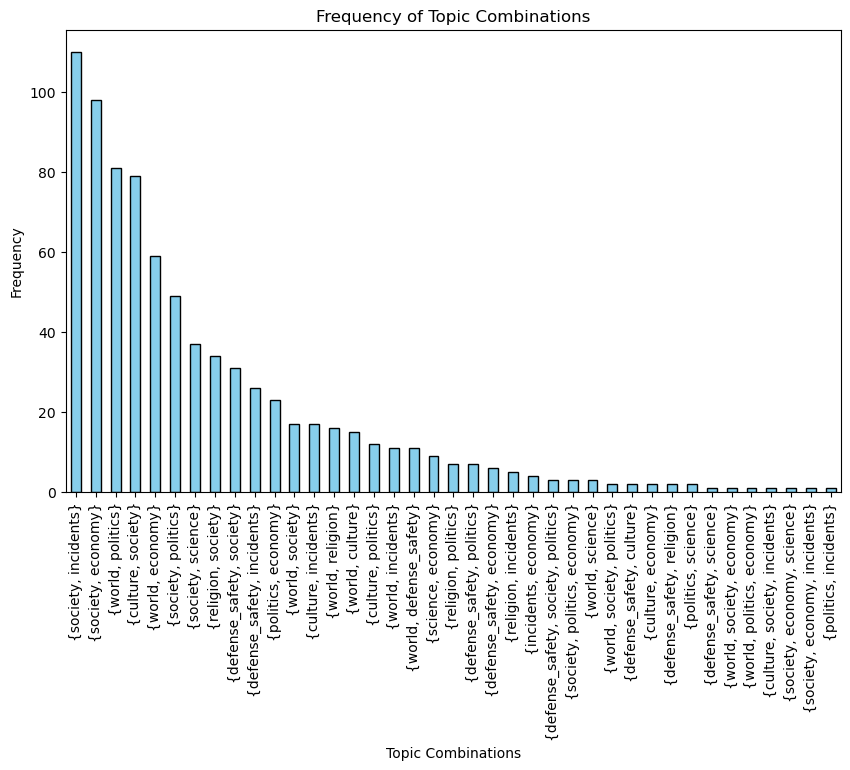

In [9]:
# Plotting the histogram
topic_combinations.value_counts().plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Topic Combinations')
plt.ylabel('Frequency')
plt.title('Frequency of Topic Combinations')
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

In [10]:
more_labels[more_labels.url.str.contains(r'https://ria.ru/20231115/putin-1909642669.html')]

,id,url,title,content,datetime,views,tags,topic
198,1909642669,https://ria.ru/20231115/putin-1909642669.html,Путин поблагодарил избиркомы за выдержку и выс...,"НОВО-ОГАРЕВО, 15 ноя - РИА Новости. Президент ...",17:23 15.11.2023,226,"['Политика', 'Владимир Путин', 'Общество', 'Ро...",politics
53940,1909642669,https://ria.ru/20231115/putin-1909642669.html,Путин поблагодарил избиркомы за выдержку и выс...,"НОВО-ОГАРЕВО, 15 ноя - РИА Новости. Президент ...",17:23 15.11.2023,229,"['Политика', 'Владимир Путин', 'Общество', 'Ро...",society


In [11]:
more_labels[more_labels.url.str.contains(r'https://ria.ru/20231113/peskov-1909107796.html')]

,id,url,title,content,datetime,views,tags,topic
224,1909107796,https://ria.ru/20231113/peskov-1909107796.html,В Кремле прокомментировали украинский след в д...,"МОСКВА, 13 ноя - РИА Новости. Украинский след ...",12:36 13.11.2023,4690,"['Россия', 'Дмитрий Песков', 'Северный поток',...",politics
8754,1909107796,https://ria.ru/20231113/peskov-1909107796.html,В Кремле прокомментировали украинский след в д...,"МОСКВА, 13 ноя - РИА Новости. Украинский след ...",12:36 13.11.2023,4690,"['Россия', 'Дмитрий Песков', 'Северный поток',...",world
54095,1909107796,https://ria.ru/20231113/peskov-1909107796.html,В Кремле прокомментировали украинский след в д...,"МОСКВА, 13 ноя - РИА Новости. Украинский след ...",12:36 13.11.2023,6369,"['Россия', 'Дмитрий Песков', 'Северный поток',...",society


In [12]:
df[df.url.str.contains(r'https://ria.ru/20231129/vino-1912535146.html')]

,id,url,title,content,datetime,views,tags,topic
5144,1912535146,https://ria.ru/20231129/vino-1912535146.html,"В Китае распробовали российское вино, рассказа...","МОСКВА, 29 ноя — РИА Новости. В Китае растет с...",08:14 29.11.2023,7500,"['Экономика', 'Китай', 'Россия', 'Павел Титов'...",world
51861,1912535146,https://ria.ru/20231129/vino-1912535146.html,"В Китае распробовали российское вино, рассказа...","МОСКВА, 29 ноя — РИА Новости. В Китае растет с...",08:14 29.11.2023,7823,"['Экономика', 'Китай', 'Россия', 'Павел Титов'...",economy


In [13]:
more_labels[more_labels.url.str.contains(r'https://radiosputnik.ru/20231129/snegopad-1912413001.html')]

,id,url,title,content,datetime,views,tags,topic
15141,1912413001,https://radiosputnik.ru/20231129/snegopad-1912...,В какие сроки коммунальные службы обязаны убра...,"Куда обращаться, если коммунальные службы не у...",02:00 29.11.2023,0,"['Сказано в эфире', 'Общество', 'ЖКХ', 'Конста...",society
39642,1912413001,https://radiosputnik.ru/20231129/snegopad-1912...,В какие сроки коммунальные службы обязаны убра...,"Куда обращаться, если коммунальные службы не у...",02:00 29.11.2023,0,"['Сказано в эфире', 'Общество', 'ЖКХ', 'Конста...",defense_safety


The other topic 'defense_safety' in the news above looks like a mistake here.

We have a small percent (3.5%) of news with several labels, so we are not going to make a 'soft' classification and trying to predict several labels for one piece of news. We concentrate on predicting the main topic label, so we keep only the first occurance of these duplicated links with the main topic tag.

In [14]:
#df = df[~df.duplicated(subset=df.columns.difference(['topic', 'views']), keep='first')]
#df.shape
df.drop_duplicates(subset='url', keep='first', inplace=True)
df.drop_duplicates(subset='id', keep='last', inplace=True)
df.shape

(44541, 8)

In [15]:
df[df.url.str.contains(r'https://ria.ru/20231129/vino-1912535146.html')]

,id,url,title,content,datetime,views,tags,topic
5144,1912535146,https://ria.ru/20231129/vino-1912535146.html,"В Китае распробовали российское вино, рассказа...","МОСКВА, 29 ноя — РИА Новости. В Китае растет с...",08:14 29.11.2023,7500,"['Экономика', 'Китай', 'Россия', 'Павел Титов'...",world


In [16]:
df[df.url.str.contains(r'https://radiosputnik.ru/20231129/snegopad-1912413001.html')]

,id,url,title,content,datetime,views,tags,topic
15141,1912413001,https://radiosputnik.ru/20231129/snegopad-1912...,В какие сроки коммунальные службы обязаны убра...,"Куда обращаться, если коммунальные службы не у...",02:00 29.11.2023,0,"['Сказано в эфире', 'Общество', 'ЖКХ', 'Конста...",society


In [17]:
df[df.url.str.contains(r'https://ria.ru/20231204/alimenty-1599485050.html')]

,id,url,title,content,datetime,views,tags,topic
52930,1599485050,https://ria.ru/20231204/alimenty-1599485050.html,Алименты на ребенка: правила расчета и взыскан...,"МОСКВА, 30 янв — РИА Новости. Платить алименты...",18:15 04.12.2023,254820,"['Общество', 'Семья', 'Дети', 'Федеральная слу...",society


In [18]:
print("Количество новостей c одинаковым url в датасете:", len(df[df.duplicated(subset=['url'])]))
print('Количество  новостей c одинаковым id в датасете:', len(df[df.duplicated(subset='id')]))

Количество новостей c одинаковым url в датасете: 0
Количество  новостей c одинаковым id в датасете: 0


Save the final data.

In [19]:
df.to_csv('news_final.csv', index=False)

## EDA

Let us check what period of time our news cover.

In [20]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.strftime("%B")
df['weekday'] = df['datetime'].dt.strftime('%A')

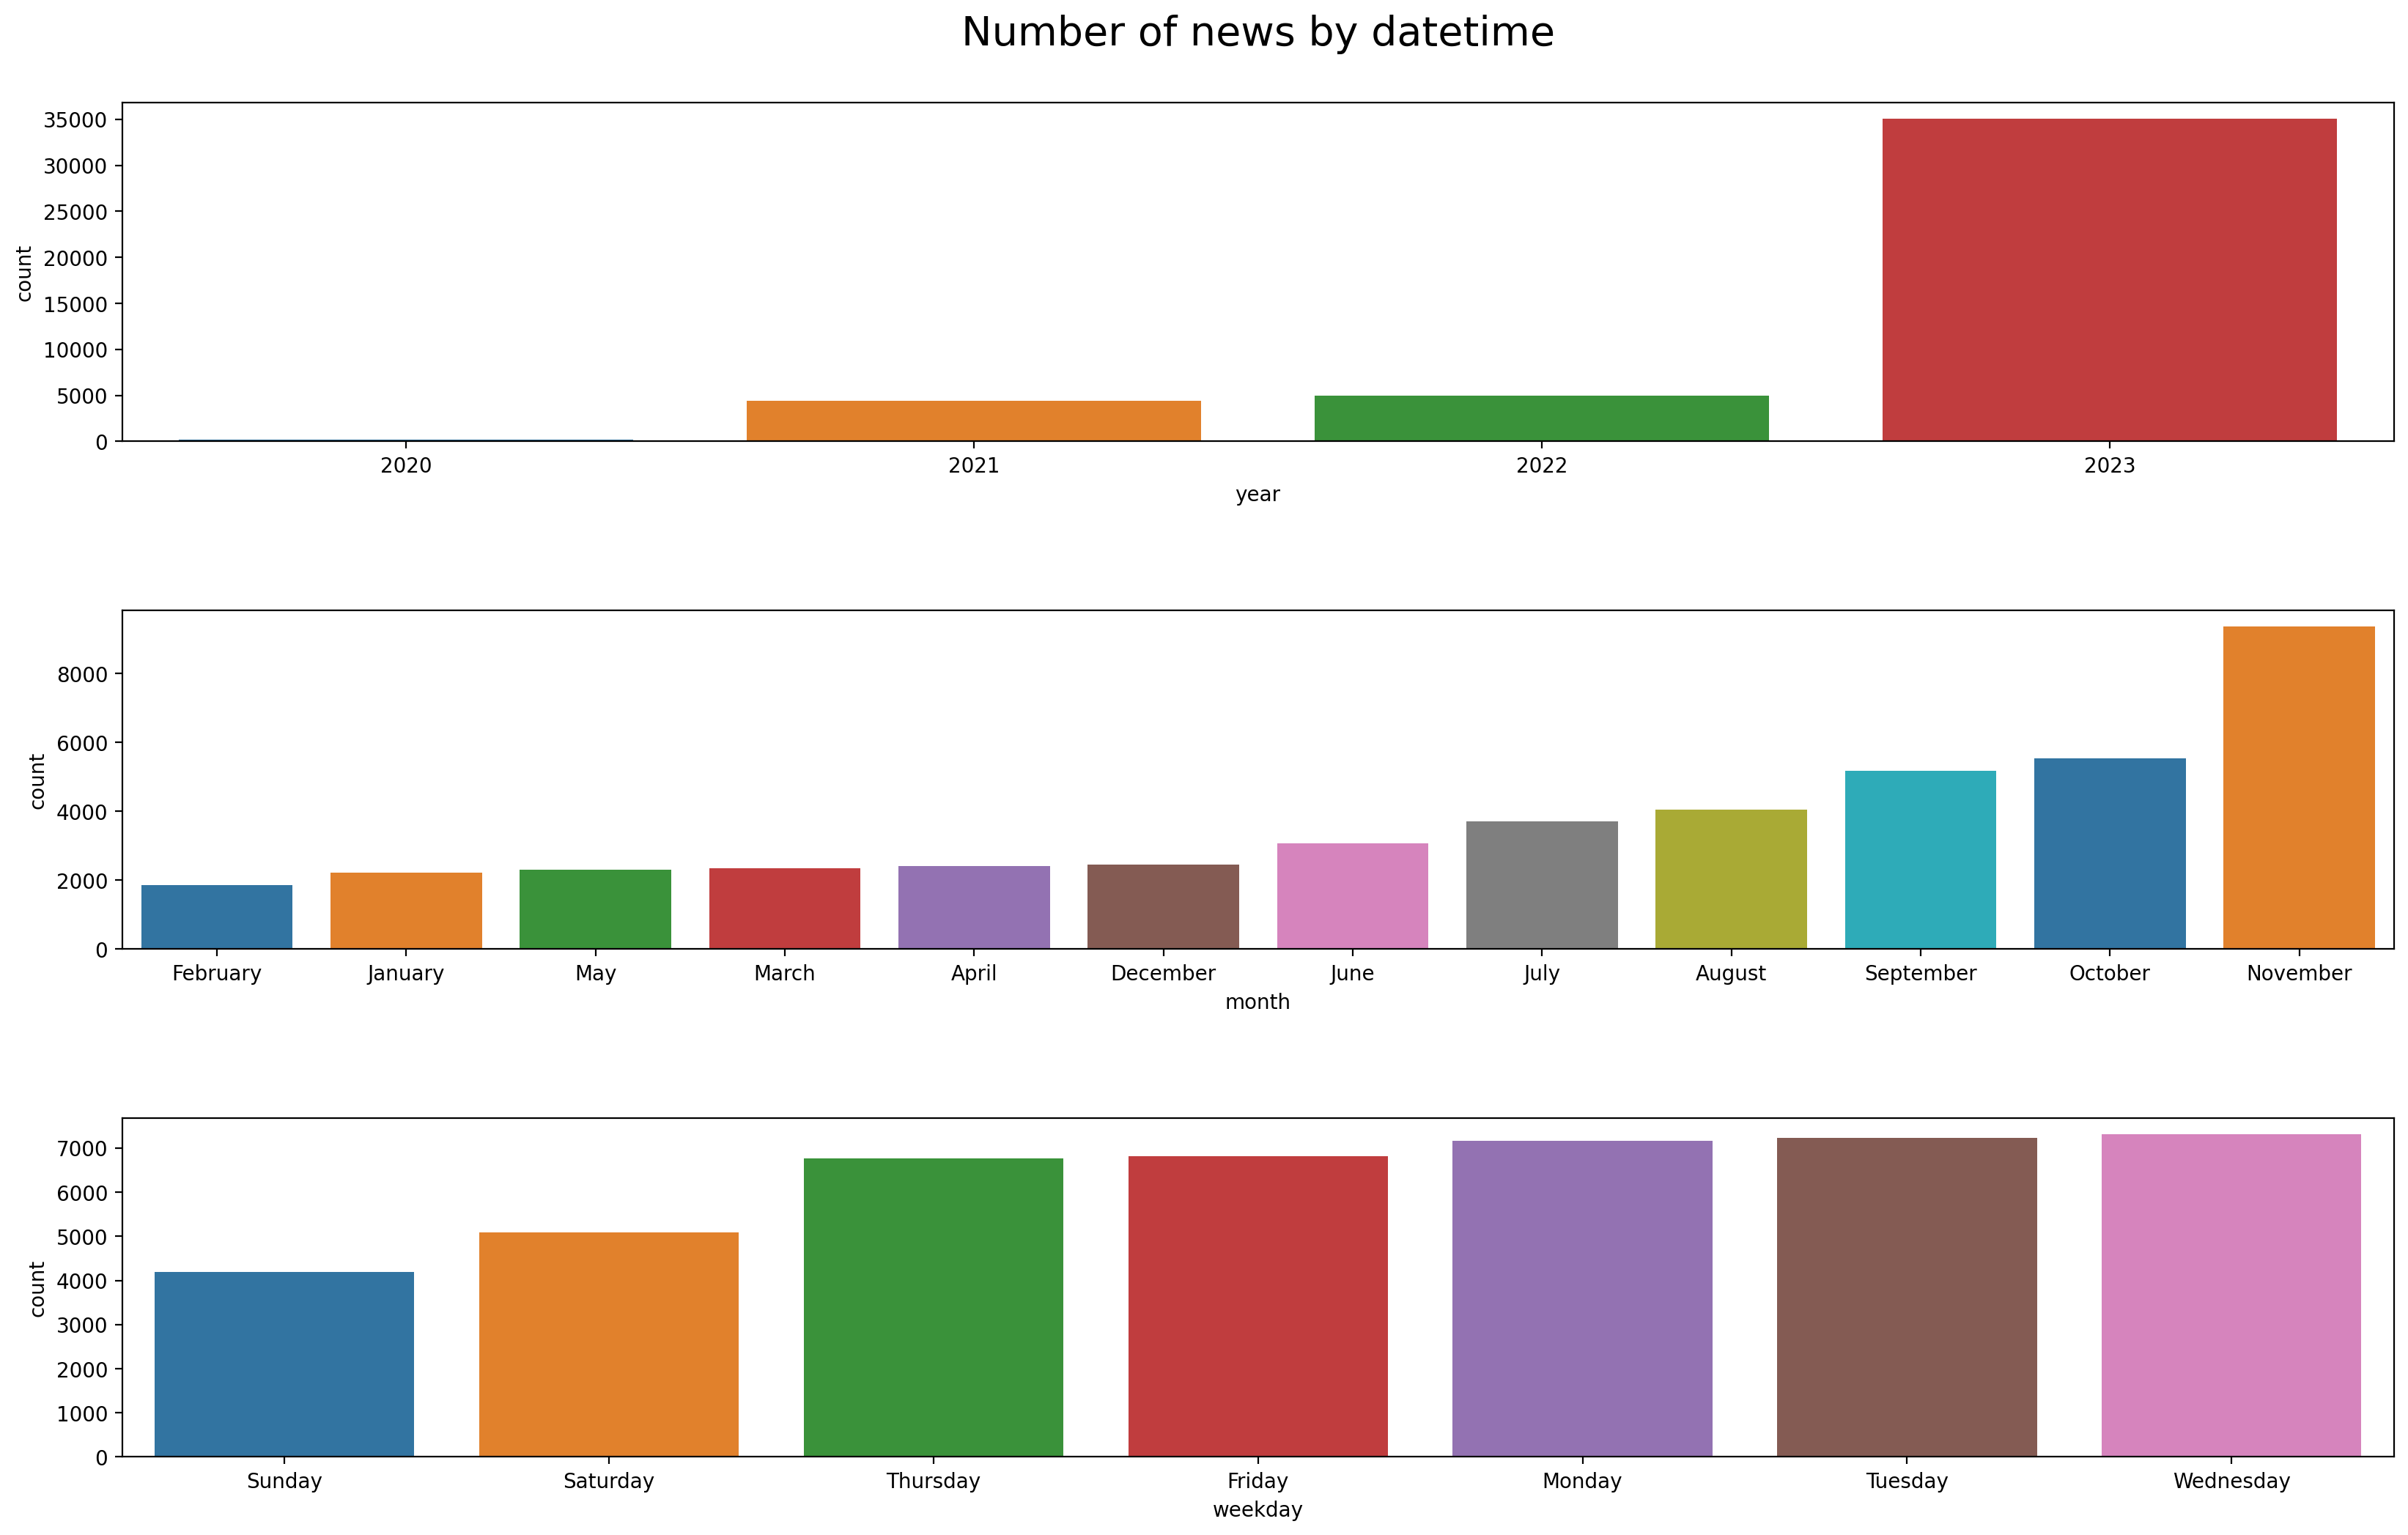

In [21]:
fig, axs = plt.subplots(3, 1, figsize=(20, 12), dpi=200)
for ind, col in enumerate(["year", "month", "weekday"]):
    sns.countplot(
        x=df[col],
        palette="tab10",
        ax=axs[ind],
        order=df[col].value_counts(ascending=True).index,
    )
axs[0].set_title("Number of news by datetime\n", fontsize=20)
plt.subplots_adjust(hspace=0.5);

We scraped the news - from the latest to the older ones.

* Most of the news is of 2023. 
* Most news come from autumn.
* The least number of news articles are published on weekends.

Let us check a frequency distribution of topics in the dataset.

In [22]:
df.topic.value_counts()

politics          5143
world             5065
incidents         5064
defense_safety    5058
religion          5022
science           5020
economy           4762
culture           4717
society           4690
Name: topic, dtype: int64

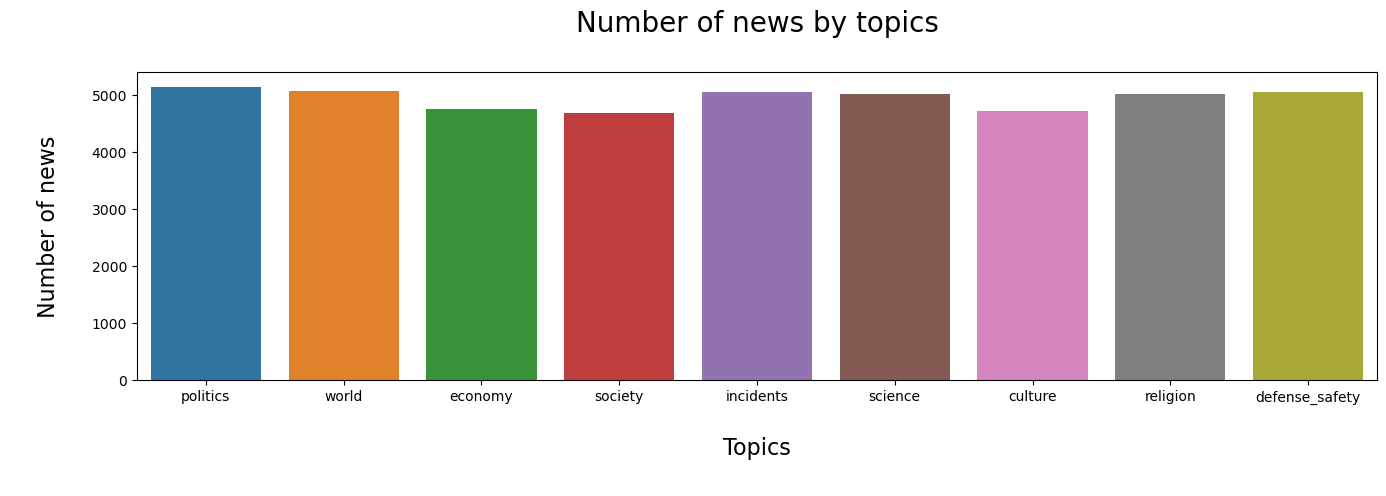

In [23]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(16, 4))
sns.countplot(x=df["topic"], palette="tab10", ax=ax)
plt.ylabel("\n Number of news \n", fontsize=16)
plt.xlabel("\nTopics\n", fontsize=16)
plt.title("Number of news by topics\n", fontsize=20)
plt.show();

## Making the balanced data

The lowest frequency in the news articles is 4690 with the category 'society'.
Therefore, we will keep 4690 articles from each category, and the rest will be discarded to perfectly  balance the topic classes.

In [24]:
df[df['year'].isin([2020])]['topic']\
.value_counts()\
.rename_axis('topic').reset_index(name='number of news')

,topic,number of news
0,science,168


In the year 2020 we have only 168 news of science topic. We discard the data for this year while making a class-balanced dataset.

In [25]:
desired_rows_per_category = 4690

# Create an empty DataFrame to store the balanced data
balanced_df = pd.DataFrame()

# Iterate over unique categories
for category in df['topic'].unique():
    
    # Sample the desired number of rows for each category
    sampled_rows = df[(df['topic'] == category) & (df['year'].isin([2021, 2022, 2023]))].sample(desired_rows_per_category)
    
    # Concatenate the sampled rows to the balanced DataFrame
    balanced_df = pd.concat([balanced_df, sampled_rows], ignore_index=True)

# Reset the index of the balanced DataFrame
balanced_df.reset_index(drop=True, inplace=True)

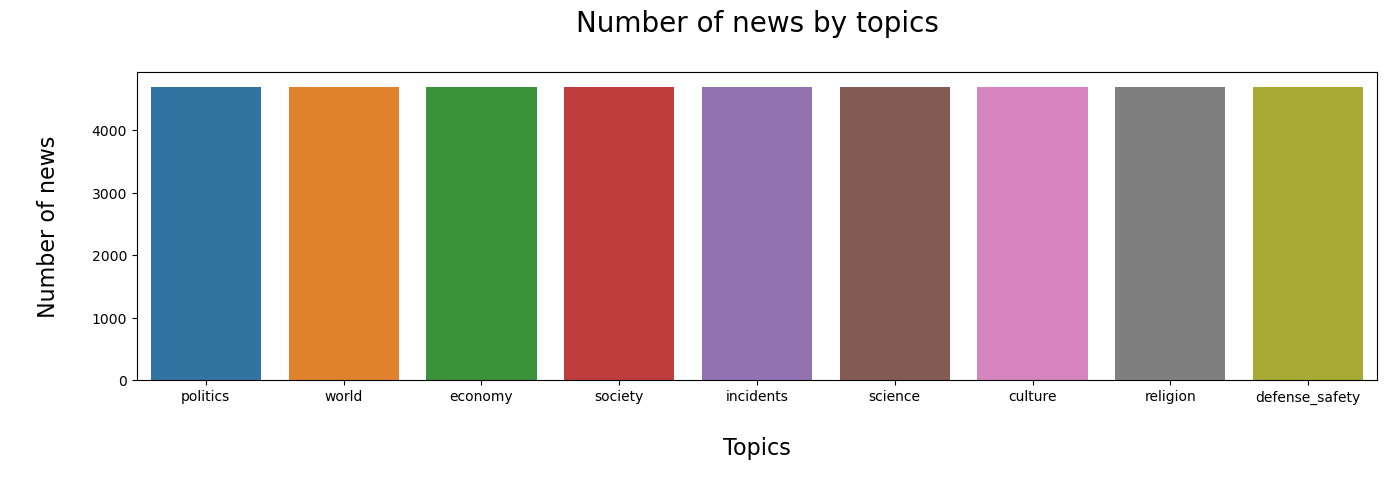

In [26]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(16, 4))
sns.countplot(x=balanced_df["topic"], palette="tab10", ax=ax)
plt.ylabel("\n Number of news \n", fontsize=16)
plt.xlabel("\nTopics\n", fontsize=16)
plt.title("Number of news by topics\n", fontsize=20)
plt.show();

In [27]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42210 entries, 0 to 42209
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        42210 non-null  int64         
 1   url       42210 non-null  object        
 2   title     42210 non-null  object        
 3   content   42210 non-null  object        
 4   datetime  42210 non-null  datetime64[ns]
 5   views     42210 non-null  int64         
 6   tags      42210 non-null  object        
 7   topic     42210 non-null  object        
 8   year      42210 non-null  int64         
 9   month     42210 non-null  object        
 10  weekday   42210 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 3.5+ MB


Let us look at the balanced dataset and the period of time it covers.

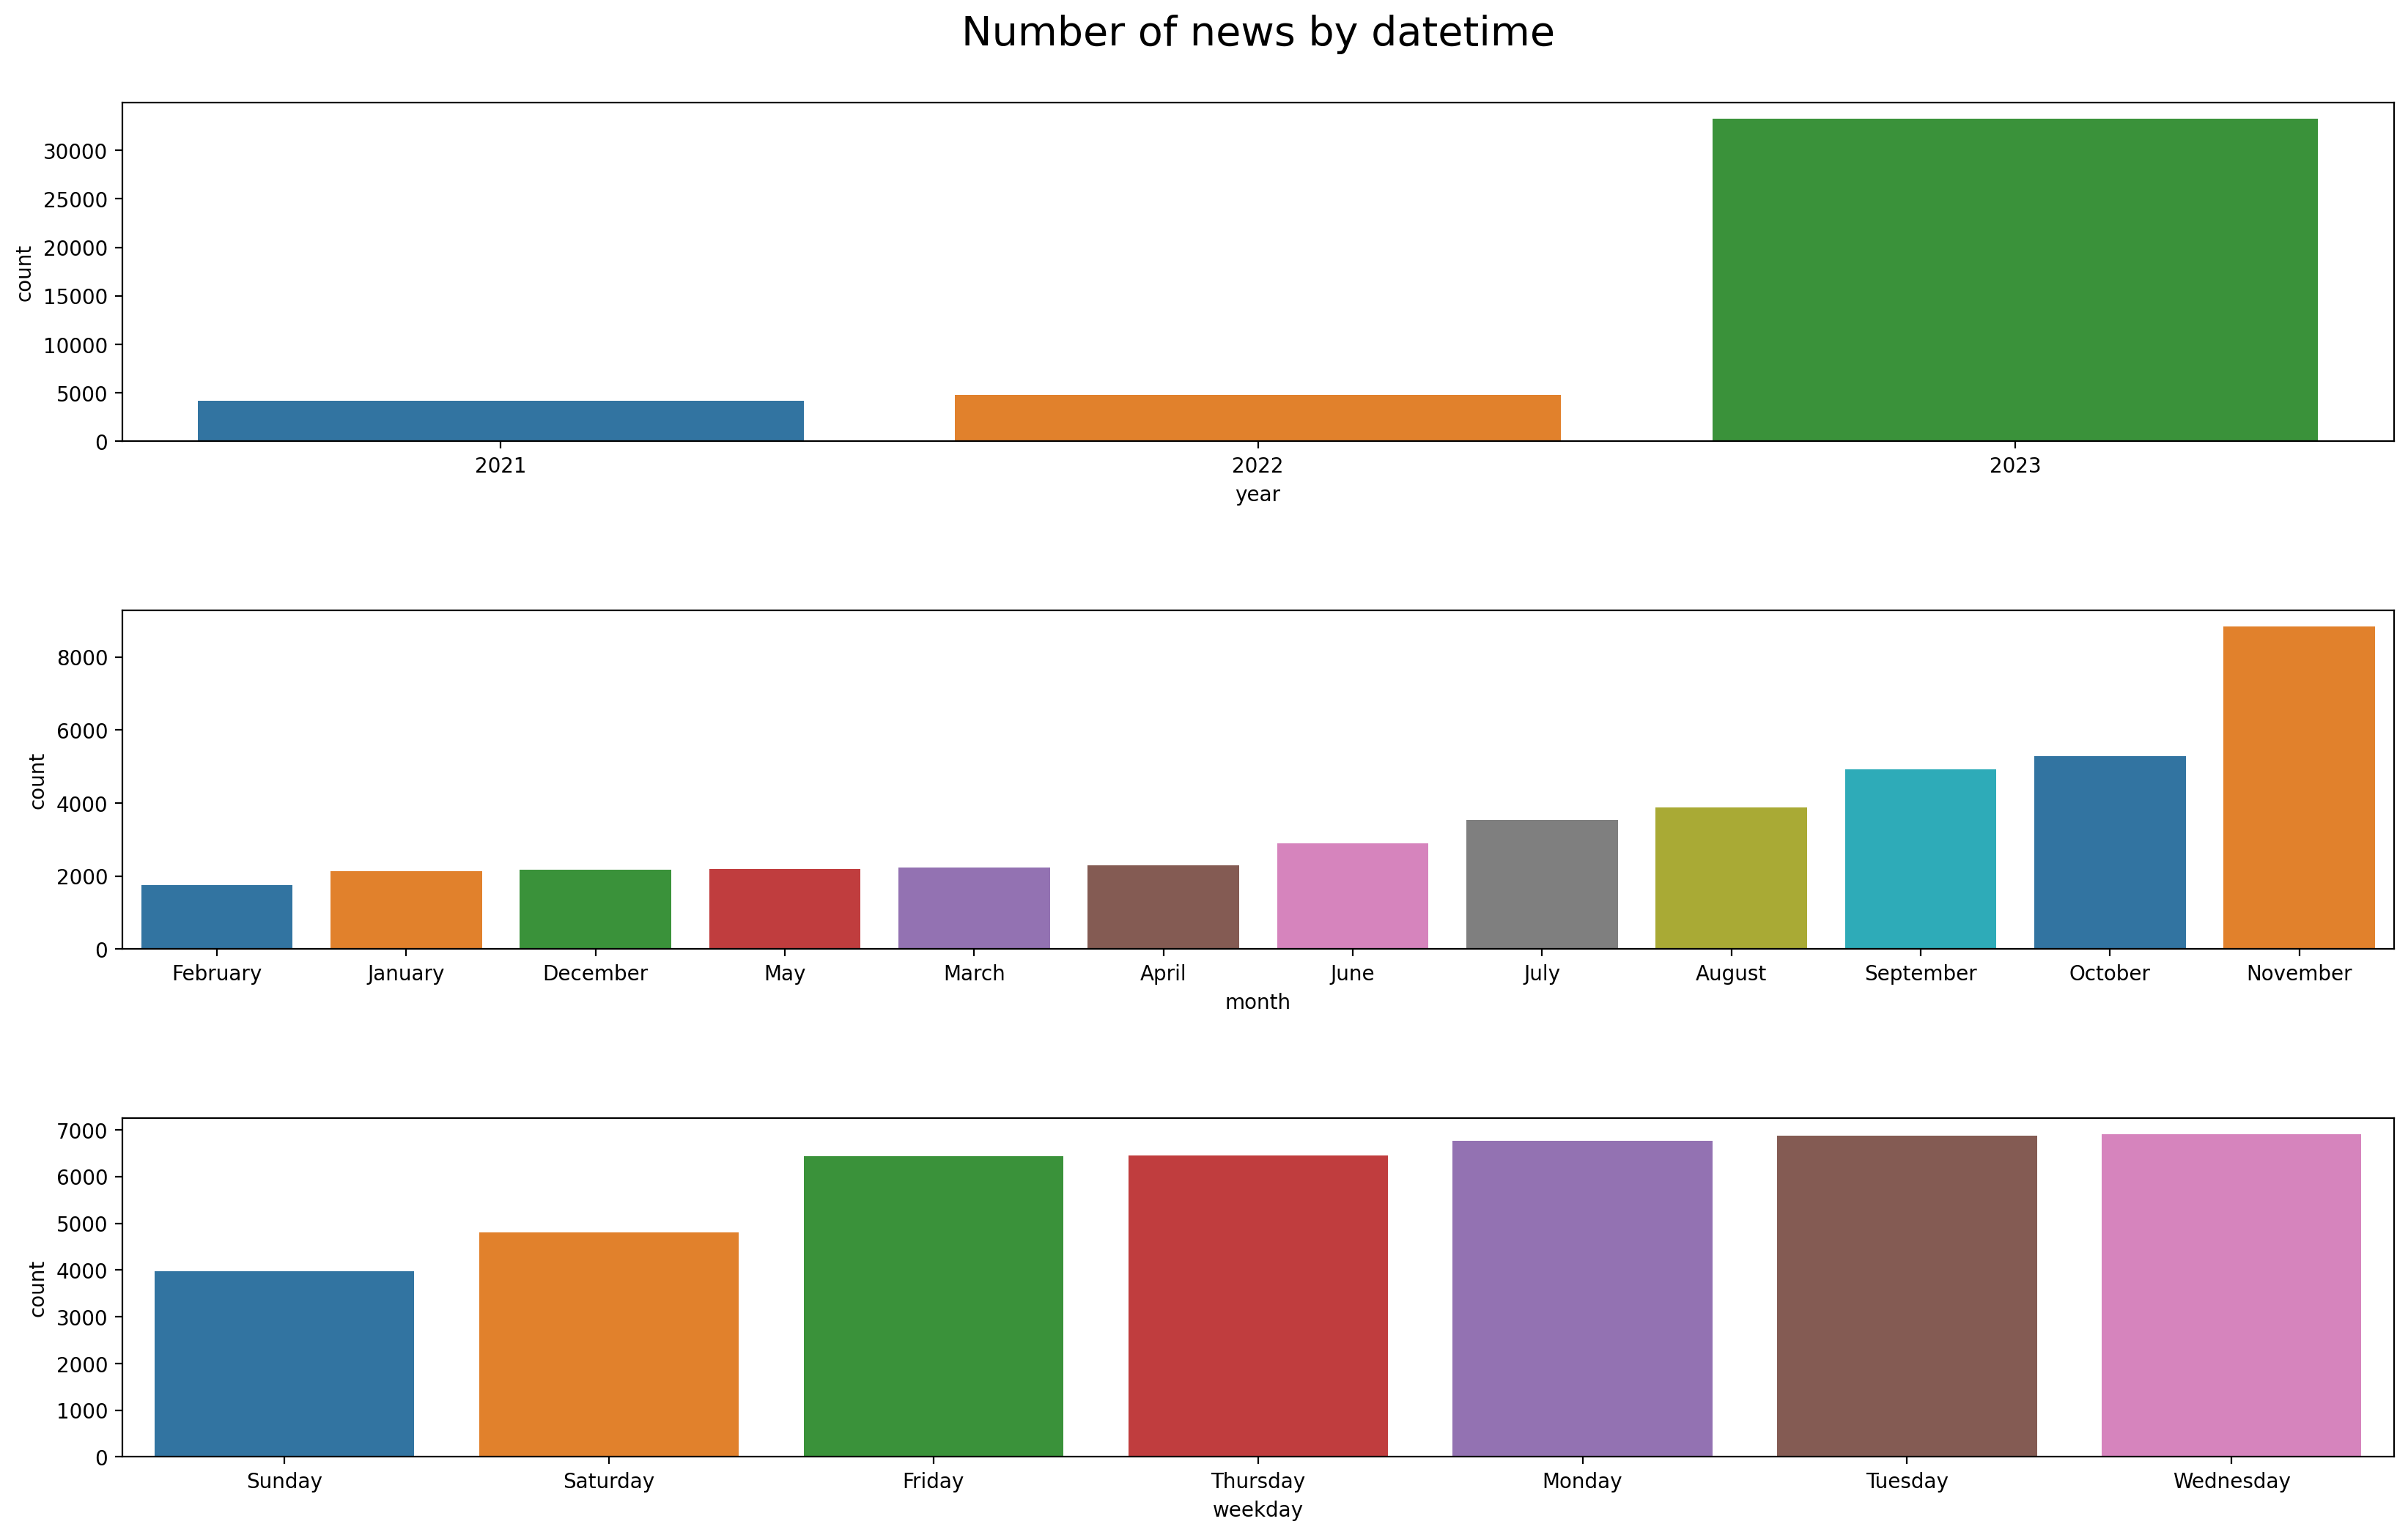

In [28]:
fig, axs = plt.subplots(3, 1, figsize=(20, 12), dpi=200)
for ind, col in enumerate(["year", "month", "weekday"]):
    sns.countplot(
        x=balanced_df[col],
        palette="tab10",
        ax=axs[ind],
        order=balanced_df[col].value_counts(ascending=True).index,
    )
axs[0].set_title("Number of news by datetime\n", fontsize=20)
plt.subplots_adjust(hspace=0.5);

In [29]:
balanced_df.datetime.min()

Timestamp('2021-01-01 08:00:00')

In [30]:
balanced_df.datetime.max()

Timestamp('2023-12-11 23:55:00')

In [31]:
balanced_df.topic.nunique()

9

In [32]:
info = pd.Series({'Number of news': balanced_df.shape[0],
                        'Number of topic classes': balanced_df.topic.nunique(),
                        'Number of news in each topic': balanced_df.topic.value_counts().iloc[0],
                        'The earliest datetime value': balanced_df.datetime.min(),
                        'The latest datetime value': balanced_df.datetime.max()
                      })

# Convert the series to a DataFrame
info = pd.DataFrame(info, columns=['values'])
info

,values
Number of news,42210
Number of topic classes,9
Number of news in each topic,4690
The earliest datetime value,2021-01-01 08:00:00
The latest datetime value,2023-12-11 23:55:00


Now in our dataset, the number of news articles by topics is perfectly balanced.

Let's take a look at how the number of views is distributed across each of the topics.

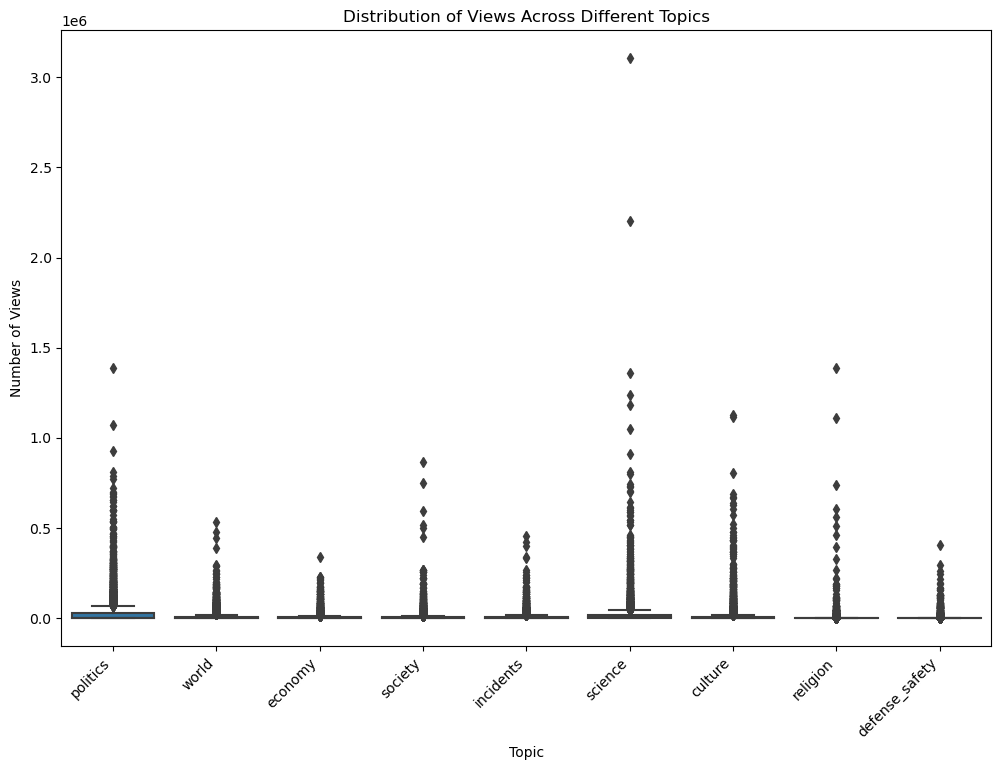

In [33]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='topic', y='views', data=balanced_df)
plt.title('Distribution of Views Across Different Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Views')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

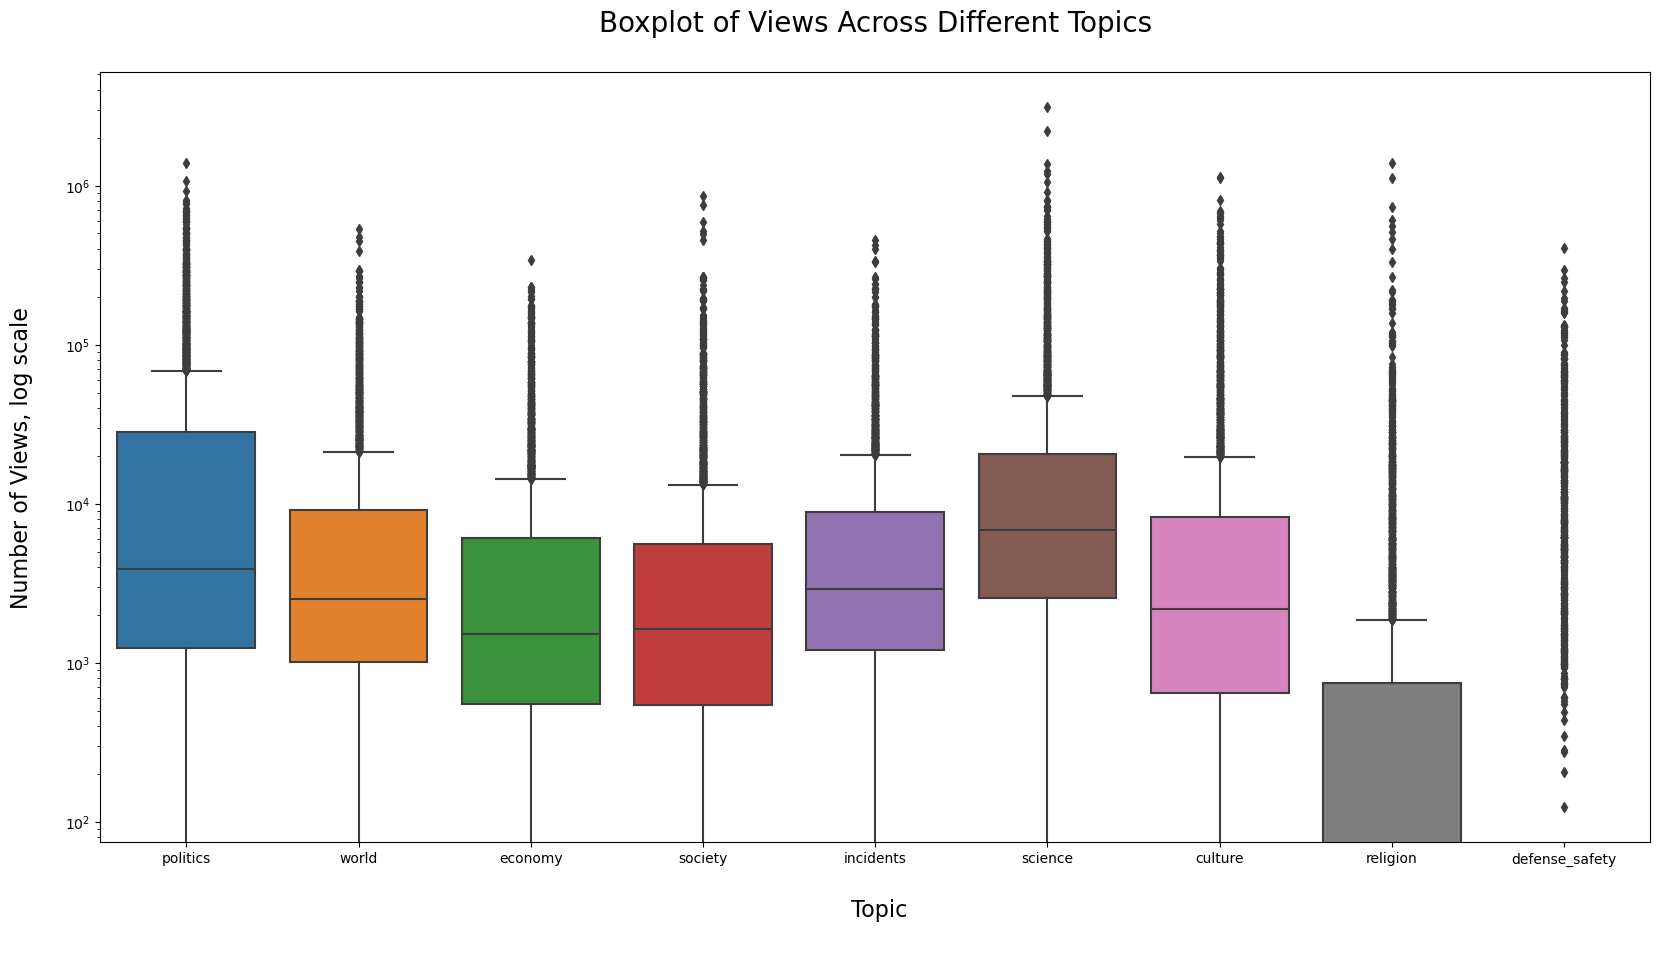

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=100)
sns.boxplot(x="topic", y="views", data=balanced_df, ax=ax)
ax.set_yscale('log')
plt.xlabel('\n Topic\n', fontsize=16)
plt.ylabel('Number of Views, log scale\n', fontsize=16)
plt.title('Boxplot of Views Across Different Topics\n', fontsize=20);

In [35]:
balanced_df[balanced_df['topic']=='religion']['views'].describe()

count    4.690000e+03
mean     4.038238e+03
std      3.534617e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.452500e+02
max      1.388247e+06
Name: views, dtype: float64

In [36]:
balanced_df[balanced_df['topic']=='defense_safety']['views'].describe()

count      4690.000000
mean       2547.160981
std       15463.522113
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      403932.000000
Name: views, dtype: float64

* We have very heavy tails in each of the topics, meaning there are articles in the dataset that stand out significantly in terms of the number of views.

* In the religion and defense_safety sections, more than a half of all news articles have 0 views, and there is a significant variation in the values. These topics have relatively low number of views compared to others. And they stand out more vividly.

* Actually we do not take this views feature into account when developing the model because levels of views can vary over time, and information about views at a specific moment may become outdated or inconsistent. The variable views does not look like a strong discriminator between the topics.

## Text statistics 

Let us check the lengths of headline and main text

In [37]:
balanced_df["len_title"] = balanced_df["title"].str.len()
balanced_df["len_content"] = balanced_df["content"].str.len()

In [38]:
balanced_df.groupby("topic").agg({'len_title':'mean'})\
.sort_values('len_title', ascending=False)

,len_title
topic,
world,64.257783
economy,63.808102
defense_safety,63.241365
society,62.723881
religion,62.529424
politics,62.511727
incidents,61.326652
science,61.219403
culture,60.065032


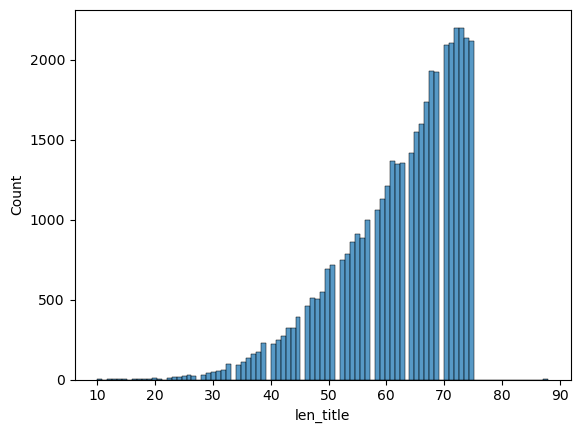

In [39]:
sns.histplot(balanced_df.len_title);

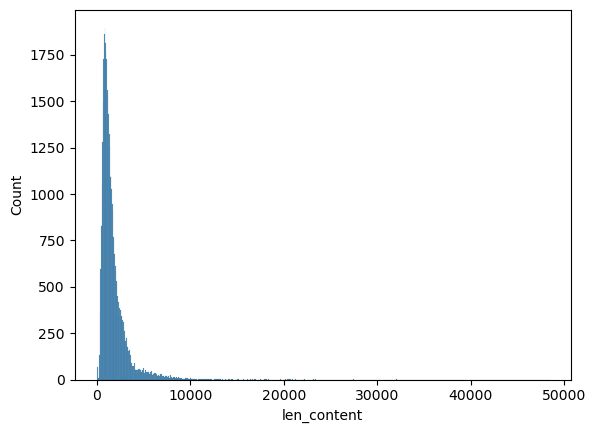

In [40]:
sns.histplot(balanced_df.len_content);

The distributions resemble log-normal distributions.
We will take the logarithm of the length of the headline and text and check the distribution.

In [41]:
balanced_df["log_len_title"] = np.log(balanced_df["len_title"])
balanced_df["log_len_content"] = np.log(balanced_df["len_content"])

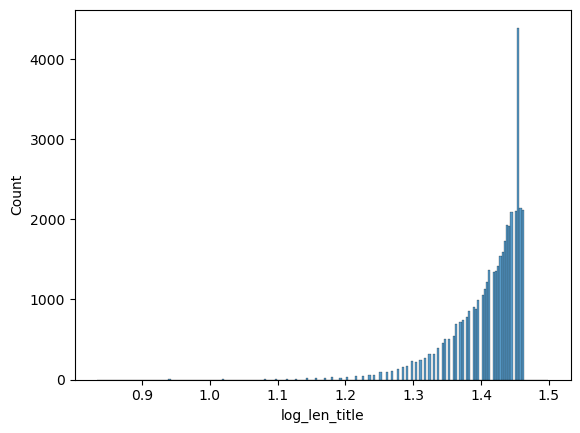

In [42]:
sns.histplot(np.log(balanced_df["log_len_title"]));

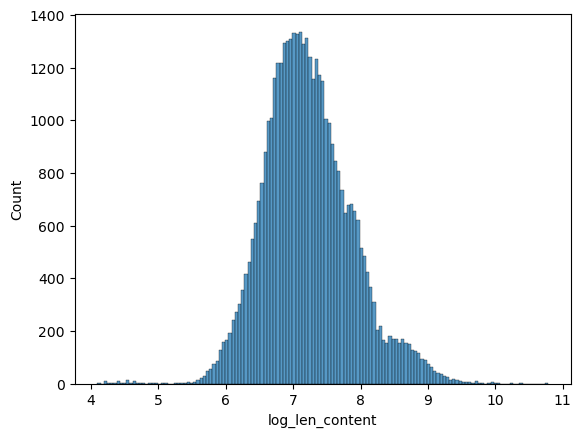

In [43]:
sns.histplot(balanced_df["log_len_content"]);

After log-transforming, the distrubution of text length became similar to normal.


We will use the Shapiro-Wilk test to assess how closely the distribution of headline lengths aligns with a log-normal distribution.

In [44]:
from scipy.stats import mannwhitneyu

x = np.random.normal(loc=balanced_df['len_title'].mean(), scale=balanced_df['len_title'].std(), size=100000)

# The Mann-Whitney test and p-significance
U1, p = mannwhitneyu(x, balanced_df['len_title'])

print('P-significance:', p)

# Decision limit is 1%
if p < 0.01:
    print('The distribution of the number of views can be considered lognormal')
else:
    print('The distribution of the number of views cant be considered lognormal')

P-significance: 1.1566796850448066e-60
The distribution of the number of views can be considered lognormal


These features can be used for building the model.

In [45]:
balanced_df.to_csv('news_final_balanced.csv', index=False)